In [7]:
import lbcred, os, random, ccdproc
from lbcred import image, interactive, tools, reduce
from astropy.nddata import CCDData
import numpy as np
from astropy.stats import mad_std
import ccdproc
from astropy.table import Column


%matplotlib inline
%config InlineBackend.figure_format='retina'

# New imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy import log
from astropy.modeling import models, fitting
from scipy.stats import chisquare

In [2]:
default_config = os.path.join(lbcred.project_dir, 'lbcreduce-config.yml')
initial_config = tools.initialize_config(default_config)
config, dir_overwritten = interactive.initialize_directories(initial_config)
image_info = image.get_image_info(config)
image.check_files(image_info, config)
image_info = image.separate_chips(image_info, config)

In [3]:
flats = image_info[np.where(image_info['imagetyp']=='flat')].copy()
bias_info = image_info[np.where(image_info['imagetyp']=='zero')].copy()
obj = image_info[np.where(image_info['imagetyp']=='object')].copy()
obj

filename,imagetyp,object,propid,filter,instrument
str31,str6,str9,str13,str8,str8
lbcr.20191221.034630-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcr.20191221.035330-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcr.20191221.040043-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcb.20191220.071505-chip2.fits,object,M81blob,OSU_LBCSBF,B-BESSEL,LBC_BLUE
lbcr.20191221.034512-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcb.20191221.031039-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.031734-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.030450-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.032428-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE


all (4608, 2304)
overscan 2098 2304 0 4608 (4608, 206)
science 0 4608 50 2098 (4608, 206)
[  0 276 277 ... 253 254 752]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


<Figure size 432x288 with 0 Axes>

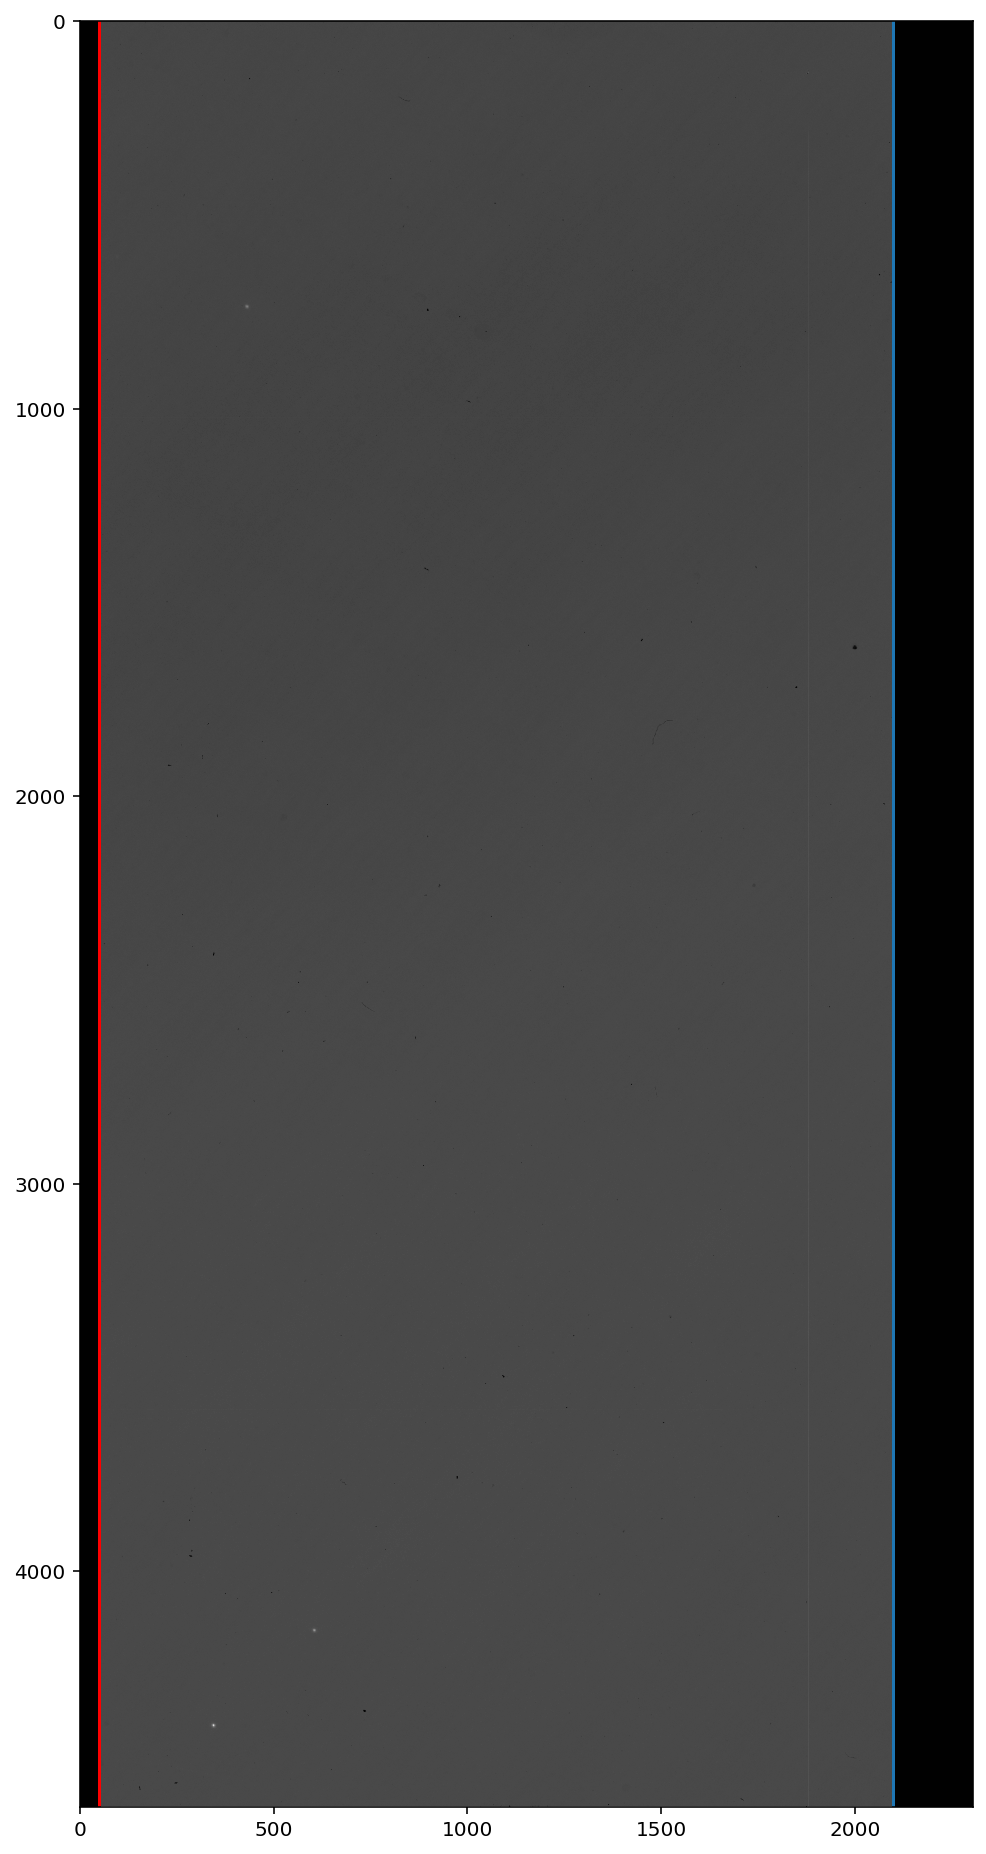

In [62]:
#tools.plot_overscan(image_info, config, 10)
# [2099:2304,1:4608]

def get_overscan(image_info, config, num_images = 1):

    # Get images to plot
    plot_files = list(image_info['filename'])
    if num_images is not None:
        plot_files = random.sample(list(plot_files), num_images)
    plt.clf()
    
    for file in plot_files:
        data = CCDData.read(os.path.join(config['out_dir'], 'midproc', file), unit=config['data_units'], hdu=config['ext'])
        print('all',data.shape)
        xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
        overscan = data.data[xmin:xmax,ymin:ymax].copy()
        print('overscan',ymin, ymax, xmin, xmax, overscan.shape)
        ymin_s, ymax_s, xmin_s, xmax_s = image.get_ccd_section(data.meta, config['science_region'])
        print('science',ymin_s, ymax_s, xmin_s, xmax_s,data.data[xmin:xmax,ymin:ymax].copy().shape)

        print(data.data[0])
        fig = plt.figure(figsize=(8,20))
        plt.axvline(x=2098, ymin=0, ymax=4607)
        plt.axvline(x=49, ymin=0, ymax=4607,c='r')
        plt.imshow(data, cmap = 'gray')
        
        return data.copy(), ymin, ymax, xmin, xmax, ymin_s, ymax_s, xmin_s, xmax_s

data, ymin, ymax, xmin, xmax, ymin_s, ymax_s, xmin_s, xmax_s = get_overscan(flats,config)

In [23]:
#tools.plot_overscan(image_info, config, 10)
# [2099:2304,1:4608]
numRows12 = int(4608/12 - 1)
numRows6 = int(4608/6 - 1)

def plot_overscan(image_info, config, imagetyp, num_images = 0, flatten_func = None, modeltype = 'legendre', axis = 0):

    log.setLevel('ERROR')

    # Get images to plot
    plot_files = list(image_info['filename'])
    if num_images is not 0:
        plot_files = random.sample(list(plot_files), num_images)
    else: num_images = len(plot_files)
    plt.clf()
    
    median12 = np.ndarray((num_images,numRows12))
    mean12 = np.ndarray((num_images,numRows12))
    sigclipped_mean12 = np.ndarray((num_images,numRows12))
    median6 = np.ndarray((num_images,numRows6))
    mean6 = np.ndarray((num_images,numRows6))
    sigclipped_mean6 = np.ndarray((num_images,numRows6))

    idx1 = 0
    x = np.arange(len(median12[idx1]))
    fig = plt.figure(figsize=(20,12))
    
    for file in plot_files:
        data = CCDData.read(os.path.join(config['out_dir'], 'midproc', file), unit=config['data_units'], hdu=config['ext'])
        xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
        overscan = data.data[xmin:xmax,ymin:ymax].copy()

        idx12 = 0
        idx6 = 0
        saverow12 = []
        saverow6 = []
        count = 0
        for row in overscan:
            
            saverow12 = np.append(saverow12,row)
            saverow6 = np.append(saverow6,row)
            
            if count%12 is 0 and count is not 0:

                median12[idx1][idx12] = np.median(saverow12)
                mean12[idx1][idx12] = np.mean(saverow12)
                sigclipped_mean12[idx1][idx12] = np.mean(sigma_clip(saverow12))
                saverow12=[]
                idx12 += 1
                
            if count%6 is 0 and count is not 0:

                median6[idx1][idx6] = np.median(saverow6)
                mean6[idx1][idx6] = np.mean(saverow6)
                sigclipped_mean6[idx1][idx6] = np.mean(sigma_clip(saverow6))
                saverow6=[]
                idx6 += 1
                
            count += 1
       
        if flatten_func is 'median' or flatten_func is None: 
            plt.plot(median12[idx1],label='median',c='black',linewidth=3)
            #plt.plot(median6[idx1],label='median',c='grey',linewidth=3)
        if flatten_func is 'mean' or flatten_func is None: 
            plt.plot(mean12[idx1],label='mean',c='black',linewidth=3)
            #plt.plot(mean6[idx1],label='mean',c='grey',linewidth=3)
        if flatten_func is 'sigclip' or flatten_func is None: 
            plt.plot(sigclipped_mean12[idx1],label='mean_sigclipped',c='black',linewidth=3)
            #plt.plot(sigclipped_mean6[idx1],label='mean_sigclipped',c='grey',linewidth=3)
        if flatten_func is 'nomean': 
            plt.plot(sigclipped_mean12[idx1],label='mean_sigclipped',c='darkorange')
            plt.plot(median12[idx1],label='median',c='b')
            
            
        idx1 += 1
        

    
    plt.ylabel('counts',fontsize=18)
    plt.xlabel('image row (binned)',fontsize=18)
    
    if num_images is 1: 
        
        fit = fitting.LevMarLSQFitter()
        
        # Model data
        if modeltype is 'legendre':
            model_init1 = models.Legendre1D(degree=1)
            model_init2 = models.Legendre1D(degree=2)
            model_init3 = models.Legendre1D(degree=3)
            model_init4 = models.Legendre1D(degree=4)
            model_init5 = models.Legendre1D(degree=5)
            model_init6 = models.Legendre1D(degree=6)
        elif modeltype is 'polynomial':
            model_init1 = models.Polynomial1D(degree=1)
            model_init2 = models.Polynomial1D(degree=2)
            model_init3 = models.Polynomial1D(degree=3)
            model_init4 = models.Polynomial1D(degree=4)
            model_init5 = models.Polynomial1D(degree=5)
            model_init6 = models.Polynomial1D(degree=6)
        
        if flatten_func is 'median':
            model1 = fit(model_init1, x, median12)
            model2 = fit(model_init2, x, median12)
            model3 = fit(model_init3, x, median12)
            model4 = fit(model_init4, x, median12)
            model5 = fit(model_init5, x, median12)
            model6 = fit(model_init6, x, median12)
        elif flatten_func is 'sigclip':
            model1 = fit(model_init1, x, sigclipped_mean12)
            model2 = fit(model_init2, x, sigclipped_mean12)
            model3 = fit(model_init3, x, sigclipped_mean12)
            model4 = fit(model_init4, x, sigclipped_mean12)
            model5 = fit(model_init5, x, sigclipped_mean12)
            model6 = fit(model_init6, x, sigclipped_mean12)
        
        plt.plot(x, model1(x), label=f'{modeltype}, n=1',c='dodgerblue',linewidth=2)
        plt.plot(x, model2(x), label=f'{modeltype}, n=2',c='firebrick',linewidth=2)
        plt.plot(x, model3(x), label=f'{modeltype}, n=3',c='goldenrod',linewidth=2)
        plt.plot(x, model4(x), label=f'{modeltype}, n=4',c='darkgreen',linewidth=2)
        plt.plot(x, model5(x), label=f'{modeltype}, n=5',c='darkmagenta',linewidth=2)
        plt.plot(x, model6(x), label=f'{modeltype}, n=6',c='orchid',linewidth=2)
        #print(model)
        
        plt.legend(fontsize=18)
        
        all_models = {'n1' : model1,
                  'n2' : model2,
                  'n3' : model3,
                  'n4' : model4,
                  'n5' : model5,
                  'n6' : model6}
        
        chisquare_results = [chisquare(sigclipped_mean12[0],all_models['n1'](x)).statistic,
                            chisquare(sigclipped_mean12[0],all_models['n2'](x)).statistic,
                            chisquare(sigclipped_mean12[0],all_models['n3'](x)).statistic,
                            chisquare(sigclipped_mean12[0],all_models['n4'](x)).statistic,
                            chisquare(sigclipped_mean12[0],all_models['n5'](x)).statistic,
                            chisquare(sigclipped_mean12[0],all_models['n6'](x)).statistic]
        
        plt.title(plot_files[0]+': '+ imagetyp + f' overscan model - {modeltype}, N = ' + str(num_images),fontsize=20)
        plt.savefig(f'/Users/kirstencasey/Desktop/overscan_{imagetyp}_{modeltype}_{flatten_func}_numims{num_images}.png')
        
        return all_models, sigclipped_mean12, chisquare_results
    
    plt.title(imagetyp + f' overscan model - {modeltype}, N = ' + str(num_images),fontsize=20)
    plt.savefig(f'/Users/kirstencasey/Desktop/overscan_{imagetyp}_{modeltype}_{flatten_func}_numims{num_images}.png')
        

<Figure size 432x288 with 0 Axes>

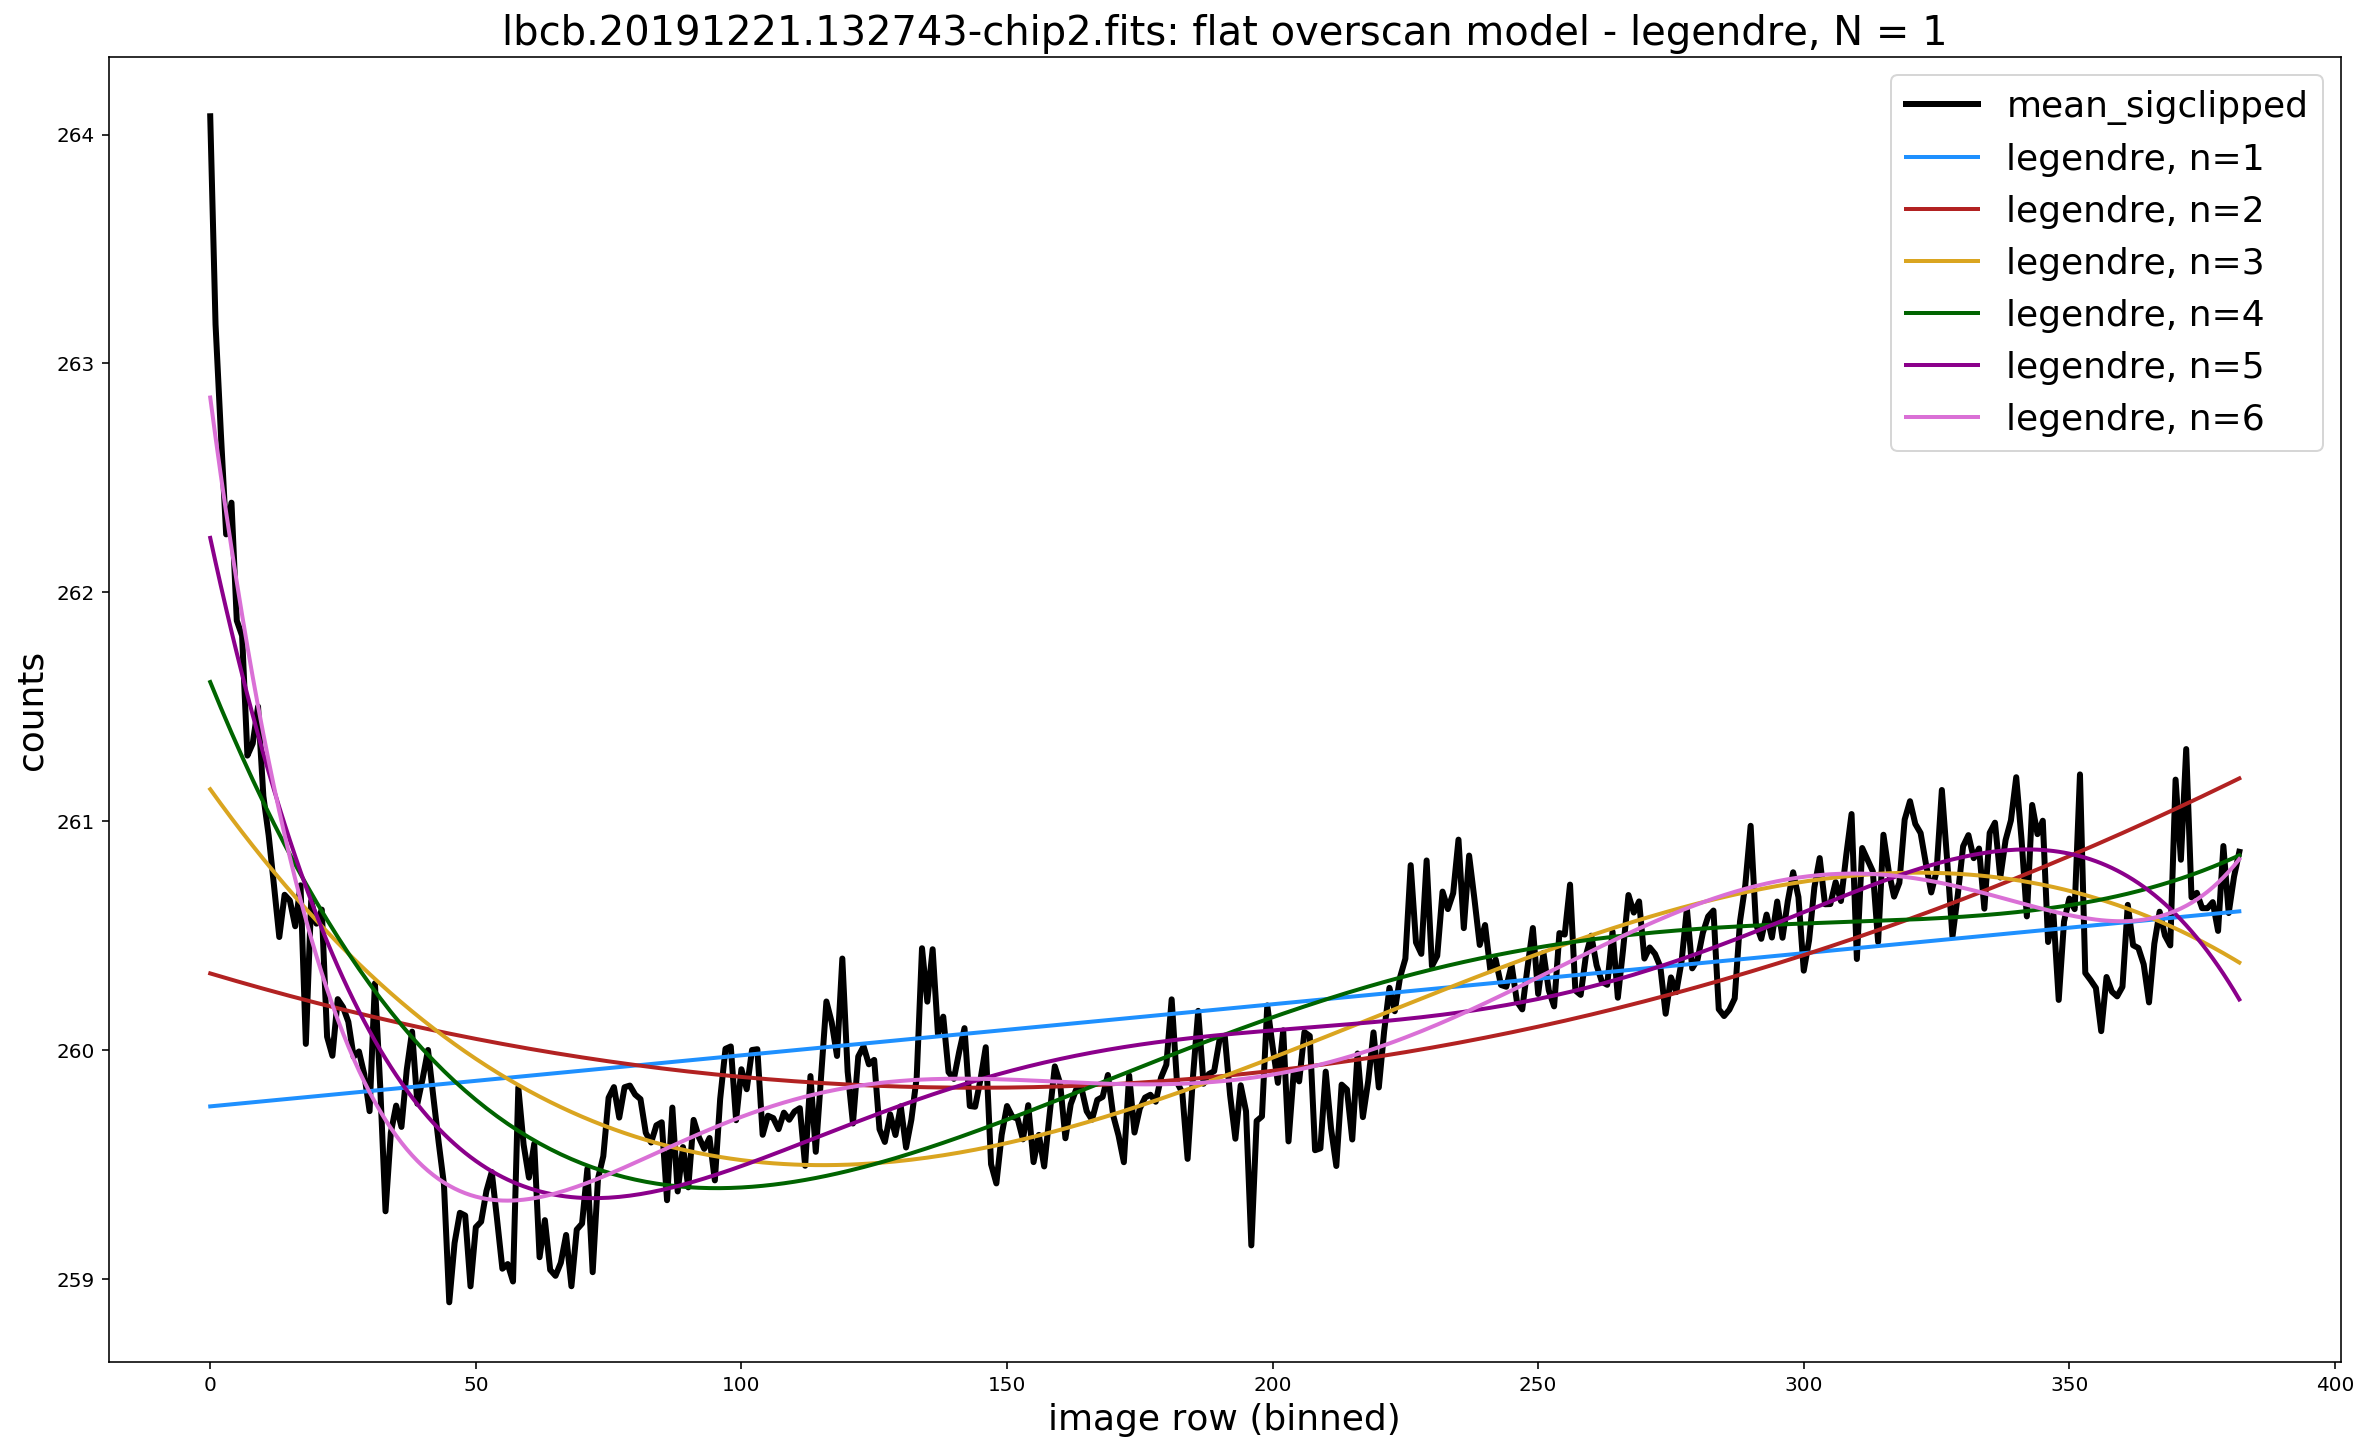

In [46]:
models_flat, clip_flat, chisquare_flat = plot_overscan(flats,config,imagetyp = 'flat', num_images = 1, flatten_func='sigclip',modeltype='legendre')

4608


<Figure size 432x288 with 0 Axes>

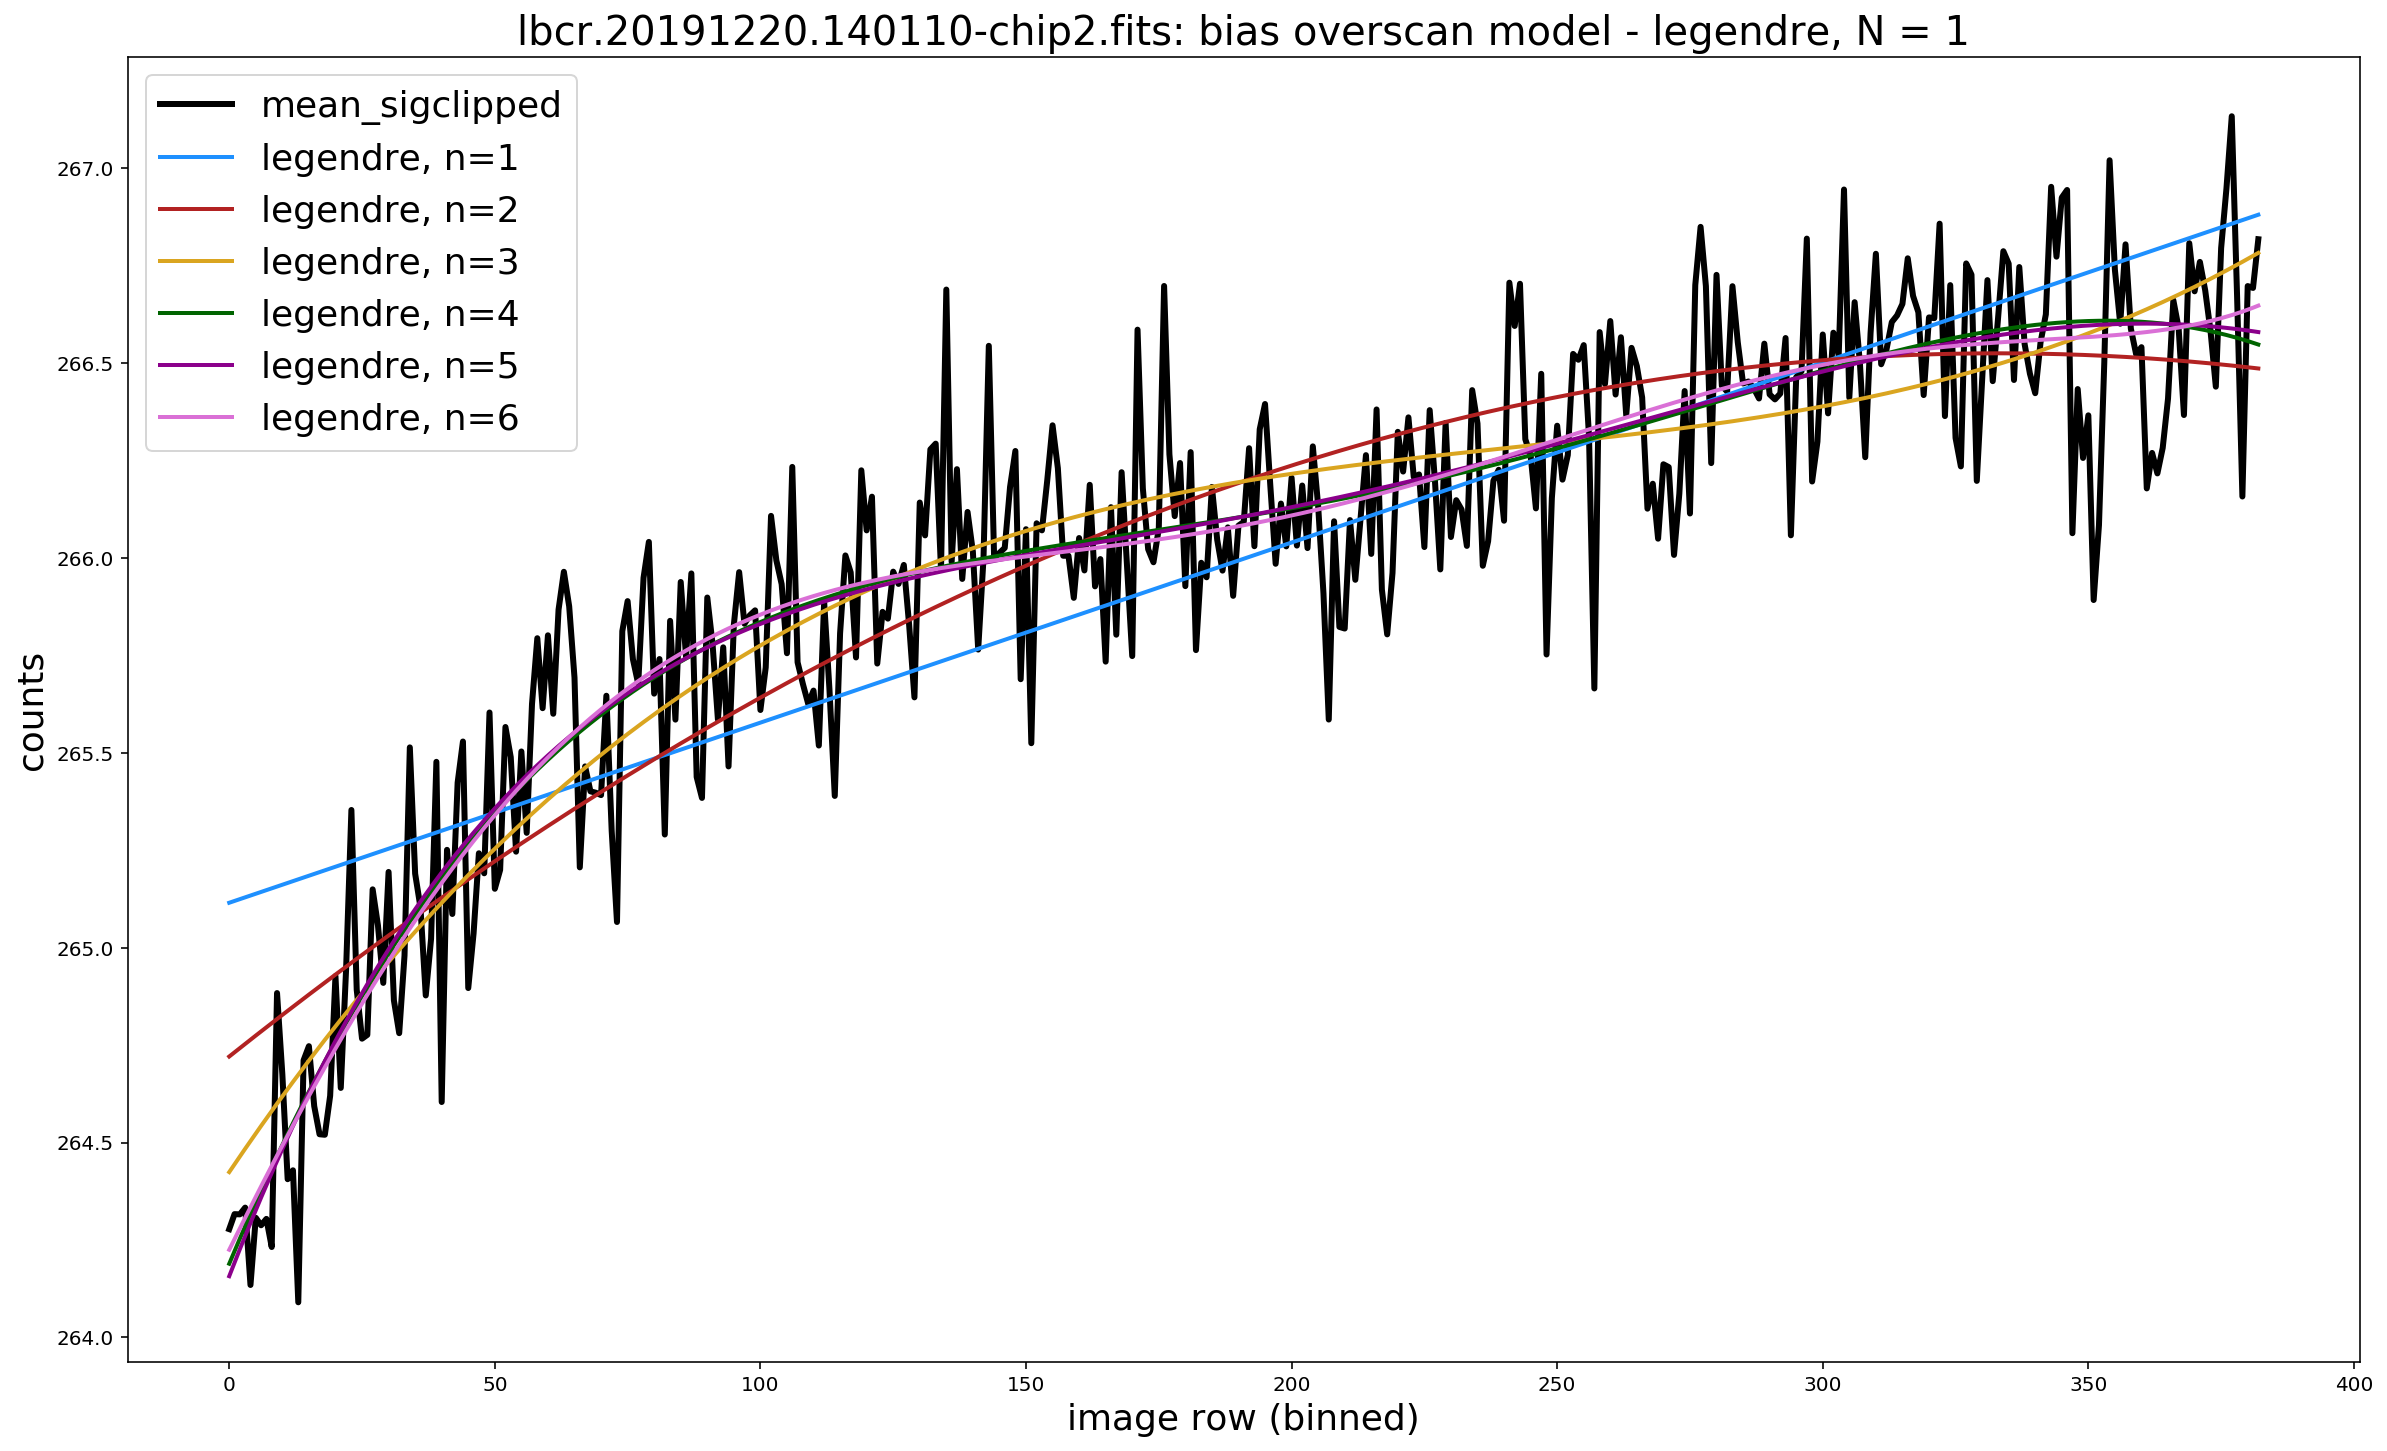

In [9]:
models_bias, clip_bias = plot_overscan(bias,config,imagetyp = 'bias', num_images = 1, flatten_func='sigclip',modeltype='legendre')

x= np.arange(clip_bias.shape[1])
result = chisquare(clip_bias[0],models_bias['n1'](x))

<Figure size 432x288 with 0 Axes>

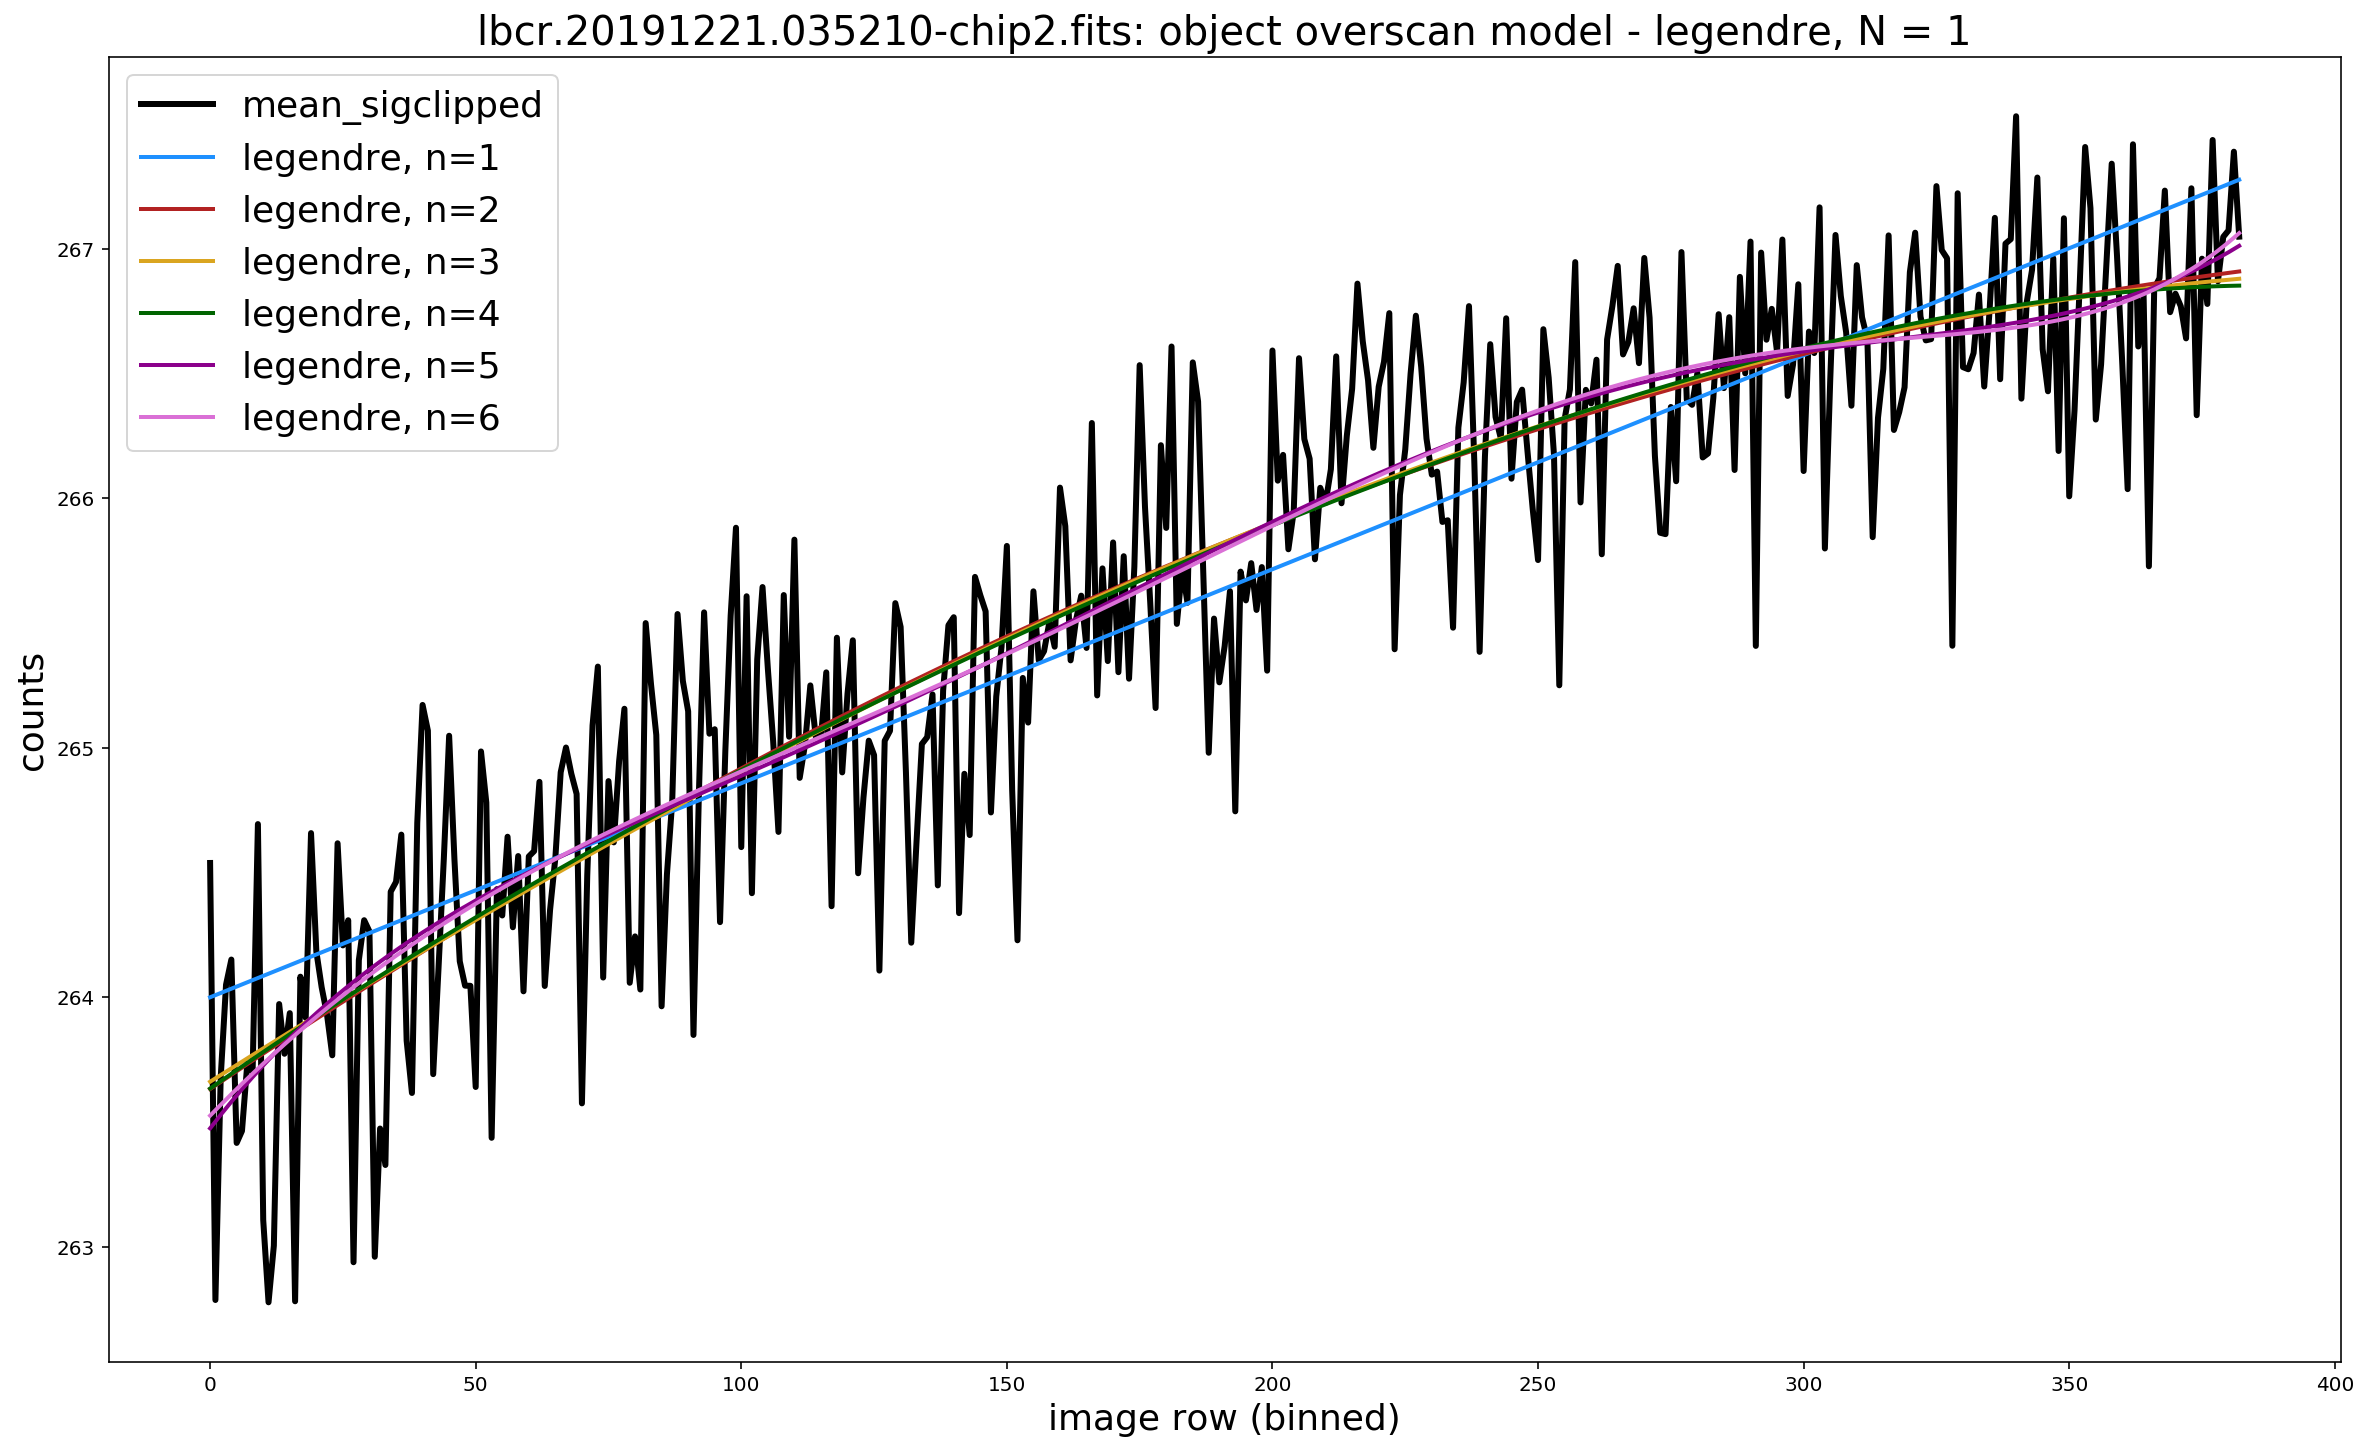

In [8]:
models_obj, clip_obj = plot_overscan(obj,config,imagetyp = 'object', num_images = 1, flatten_func='sigclip',modeltype='legendre')

#x= np.arange(clip_obj.shape[1])
#chisquare(clip_obj[0],models_obj['n1'](x))

In [9]:
bias = image_info[np.where(image_info['imagetyp']=='zero')].copy()
data = CCDData.read(os.path.join(config['out_dir'], 'midproc', bias[0]['filename']), unit=config['data_units'], hdu=config['ext'])
xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
data_o = ccdproc.subtract_overscan(data, overscan=data[xmin:xmax,ymin:ymax], median=True, model=models.Legendre1D(degree=2))

In [10]:
x= np.arange(clip_obj.shape[1])
print('n=1: ',chisquare(clip_obj[0],models_obj['n1'](x), ddof=1))
print('n=2: ',chisquare(clip_obj[0],models_obj['n2'](x), ddof=2))
print('n=3: ',chisquare(clip_obj[0],models_obj['n3'](x), ddof=3))
print('n=4: ',chisquare(clip_obj[0],models_obj['n4'](x), ddof=4))
print('n=5: ',chisquare(clip_obj[0],models_obj['n5'](x), ddof=5))
print('n=6: ',chisquare(clip_obj[0],models_obj['n6'](x), ddof=6))

n=1:  Power_divergenceResult(statistic=0.328143154030789, pvalue=1.0)
n=2:  Power_divergenceResult(statistic=0.28857261213107943, pvalue=1.0)
n=3:  Power_divergenceResult(statistic=0.2883922068163822, pvalue=1.0)
n=4:  Power_divergenceResult(statistic=0.2882610483161687, pvalue=1.0)
n=5:  Power_divergenceResult(statistic=0.2846663329511488, pvalue=1.0)
n=6:  Power_divergenceResult(statistic=0.2843387865957937, pvalue=1.0)


In [11]:
'''
def redchisq(ydata,ymod,deg=2,sd=None):
    #http://astropython.blogspot.com/2012/02/computing-chi-squared-and-reduced-chi.html
        
    # Chi-square statistic  
    if sd==None:  
       chisq=np.sum((ydata-ymod)**2)  
    else:  
       chisq=np.sum( ((ydata-ymod)/sd)**2 )  

    # Number of degrees of freedom
    nu=ydata.size-1-deg  

    return chisq/nu 

print('n=1: ',redchisq(clip_obj[0],models_obj['n1'](x),deg=1))
print('n=2: ',redchisq(clip_obj[0],models_obj['n2'](x),deg=2))
print('n=3: ',redchisq(clip_obj[0],models_obj['n3'](x),deg=3))
print('n=4: ',redchisq(clip_obj[0],models_obj['n4'](x),deg=4))
print('n=5: ',redchisq(clip_obj[0],models_obj['n5'](x),deg=5))
print('n=6: ',redchisq(clip_obj[0],models_obj['n6'](x),deg=6))
'''

In [14]:
arr = [0.328143154030789,0.28857261213107943,0.2883922068163822,0.2882610483161687,0.2846663329511488,0.2843387865957937]
np.median(arr) + 4*mad_std(arr)

0.2999095439228103

In [51]:
print(chisquare_flat)
limit = np.median(chisquare_flat) + 1*mad_std(chisquare_flat)
print(limit)

[0.4853720933604835, 0.38382068973283734, 0.2432732129957856, 0.20548373017998636, 0.14811608073638072, 0.10066636198827907]
0.37261979059457023


In [32]:
def bias(bias_type, config, file_info, combine_options_overwrite):

    raw_bias_info = file_info[np.where(file_info['imagetyp']==config['bias_image_keyword'])]
    processed_bias_info = raw_bias_info.copy()
    out_names = []
    print('num bias images: ',len(processed_bias_info))
    combine_options, overscan_options, legendre_options, use_variable_legendre, variable_legendre_options = tools.get_config_options('bias', config)
    combine_options = combine_options_overwrite
    # Make 2D bias image
    if bias_type == '2Dbias':
        # Loop through bias images
        for bias_im in raw_bias_info:
            # Get data
            data = CCDData.read(os.path.join(config['out_dir'], 'midproc', bias_im['filename']), unit=config['data_units'], hdu=config['ext'])

            # Trim overscan region
            xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['science_region'])
            data_trimmed = ccdproc.trim_image(data[xmin:xmax,ymin:ymax])
            data_trimmed.meta[config['data_region']] = f'[1:{data_trimmed.shape[1]},1:{data_trimmed.shape[0]}]'

            # Save trimmed image
            out_names.append(os.path.join(config['out_dir'], 'midproc', bias_im['filename'].replace('.fits','_T.fits')))
            primary_hdu = fits.open(os.path.join(config['out_dir'], 'midproc',  bias_im['filename']))[0]
            image_hdu = fits.ImageHDU(data=data_trimmed,header=data_trimmed.header)
            fits.HDUList([primary_hdu,image_hdu]).writeto(out_names[-1])


    # Make zero-frame bias image
    if bias_type == 'zero':
        # Loop through bias images
        for bias_im in raw_bias_info:
            # Get data
            data = CCDData.read(os.path.join(config['out_dir'], 'midproc', bias_im['filename']), unit=config['data_units'], hdu=config['ext'])

            # Subtract overscan   ################################ TRYING NEW FUNC HERE ################################
            xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
            if use_variable_legendre:
                new_model = image.find_best_overscan_legendre_model(data[xmin:xmax,ymin:ymax], bias_im, legendre_options, out_dir=os.path.join(config['out_dir'], 'plots'), **variable_legendre_options)
                overscan_options['model'] = new_model
            data_o = ccdproc.subtract_overscan(data, overscan=data[xmin:xmax,ymin:ymax], **overscan_options)

            # Trim overscan region
            xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['science_region'])
            data_ot = ccdproc.trim_image(data_o[xmin:xmax,ymin:ymax])
            data_ot.meta[config['data_region']] = f'[1:{data_ot.shape[1]},1:{data_ot.shape[0]}]'

            # Save overscan subtracted, trimmed image
            out_names.append(os.path.join(config['out_dir'], 'midproc', bias_im['filename'].replace('.fits','_OT.fits')))
            primary_hdu = fits.open(os.path.join(config['out_dir'], 'midproc',  bias_im['filename']))[0]
            image_hdu = fits.ImageHDU(data=data_ot,header=data_ot.header)
            fits.HDUList([primary_hdu,image_hdu]).writeto(out_names[-1])

    processed_bias_info['filename'] = Column(data=out_names, name='filename')

    # Combine images to make master bias
    for chip in config['chips']:
        master_name = os.path.join(config['out_dir'], 'midproc', 'masterbias_' + bias_type + chip)

        # Get correct chip
        mask = [idx for idx,fi in enumerate(processed_bias_info['filename']) if chip in fi]
        chip_info = processed_bias_info[mask]
        chip_info_R = chip_info[np.where(chip_info['instrument']==config['lbc_red'])]
        chip_info_B = chip_info[np.where(chip_info['instrument']==config['lbc_blue'])]
        print(chip_info_R['filename'])
        # Sort by instrument
        masterbias_R = ccdproc.combine(np.asarray(chip_info_R['filename']), output_file=master_name+'_R.fits', unit=config['data_units'], **combine_options)
        masterbias_B = ccdproc.combine(np.asarray(chip_info_B['filename']), output_file=master_name+'_B.fits', unit=config['data_units'], **combine_options)

        
    return masterbias_R, masterbias_B, combine_options
        
default_config = os.path.join(lbcred.project_dir, 'lbcreduce-config.yml')
initial_config = tools.initialize_config(default_config)
config, dir_overwritten = interactive.initialize_directories(initial_config)
image_info = image.get_image_info(config)
image.check_files(image_info, config)
image_info = image.separate_chips(image_info, config) 
bias_info = image_info[np.where(image_info['imagetyp']=='zero')].copy()
masterbias_R, masterbias_B, combine_options = bias('2Dbias', config, bias_info, combine_options_test)

num bias images:  4


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


                             filename                             
------------------------------------------------------------------
/Users/kirstencasey/temp/midproc/lbcr.20191220.140043-chip2_T.fits
/Users/kirstencasey/temp/midproc/lbcr.20191220.140110-chip2_T.fits
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


In [33]:
masterbias_R

CCDData([[263. , 265.5, 267. , ..., 256.5, 267. , 266. ],
         [270.5, 268.5, 263. , ..., 260.5, 265. , 266. ],
         [264. , 264. , 267. , ..., 260. , 265.5, 264.5],
         ...,
         [265.5, 272.5, 270.5, ..., 264.5, 262. , 264. ],
         [276. , 266.5, 269.5, ..., 269. , 268. , 268. ],
         [274. , 278.5, 270. , ..., 268.5, 264.5, 267. ]])

In [26]:
combine_options

{'method': 'average',
 'weights': None,
 'scale': None,
 'mem_limit': 16000000000.0,
 'clip_extrema': True,
 'nlow': 1,
 'nhigh': 1,
 'minmax_clip': False,
 'minmax_clip_min': None,
 'minmax_clip_max': None,
 'sigma_clip': True,
 'sigma_clip_low_thresh': 5,
 'sigma_clip_high_thresh': 5,
 'sigma_clip_func': <function numpy.ma.extras.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>,
 'sigma_clip_dev_func': <function astropy.stats.funcs.mad_std(data, axis=None, func=None, ignore_nan=False)>,
 'dtype': None,
 'combine_uncertainty_function': None}

In [27]:
combine_options_test = combine_options

In [28]:
combine_options_test['clip_extrema'] = False


#method='average', weights=None, scale=None, mem_limit=16000000000.0, 
#clip_extrema=False, nlow=1, nhigh=1, minmax_clip=False, minmax_clip_min=None, minmax_clip_max=None, 
#sigma_clip=False, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3, sigma_clip_func=<numpy.ma.core._frommethod object at 0x7f5412bf0d68>, 
#sigma_clip_dev_func=<numpy.ma.core._frommethod object at 0x7f5412bf0fd0>, dtype=None, combine_uncertainty_function=None, **ccdkwargs

In [29]:
combine_options_test

{'method': 'average',
 'weights': None,
 'scale': None,
 'mem_limit': 16000000000.0,
 'clip_extrema': False,
 'nlow': 1,
 'nhigh': 1,
 'minmax_clip': False,
 'minmax_clip_min': None,
 'minmax_clip_max': None,
 'sigma_clip': True,
 'sigma_clip_low_thresh': 5,
 'sigma_clip_high_thresh': 5,
 'sigma_clip_func': <function numpy.ma.extras.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>,
 'sigma_clip_dev_func': <function astropy.stats.funcs.mad_std(data, axis=None, func=None, ignore_nan=False)>,
 'dtype': None,
 'combine_uncertainty_function': None}

In [36]:
import os

os.path.isfile('/Users/kirstencasey/coadd.fits')

True